In [1]:
import re
import pickle
import numpy as np
import pandas as pd
# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Import libraries
from collections import defaultdict
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer
import transformers
import tensorflow as tf
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import zipfile
# Keras 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Path to the zipped file
zip_path = '/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip'
zip_path2 = '/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip'
# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as z:
    # Extract the tsv file name from the zip file
    tsv_file = z.namelist()[0]
    
    # Read the tsv file using pandas directly from the zipfile object
    with z.open(tsv_file) as f:
        train_df = pd.read_csv(f, delimiter='\t')

with zipfile.ZipFile(zip_path2, 'r') as z:
    # Extract the tsv file name from the zip file
    tsv_file = z.namelist()[0]
    
    # Read the tsv file using pandas directly from the zipfile object
    with z.open(tsv_file) as f:
        test_df = pd.read_csv(f, delimiter='\t')


In [3]:
train_df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [4]:
train_df = train_df[['sentiment' , 'review']]

In [5]:
train_df['review'] = train_df['review'].apply(lambda x : x.lower())

In [6]:
train_df.head()

,sentiment,review
0,1,with all this stuff going down at the moment w...
1,1,"\the classic war of the worlds\"" by timothy hi..."
2,0,the film starts with a manager (nicholas bell)...
3,0,it must be assumed that those who praised this...
4,1,superbly trashy and wondrously unpretentious 8...


In [7]:
train_df.shape

(25000, 2)

In [8]:
train_df['review'][0]

"with all this stuff going down at the moment with mj i've started listening to his music, watching the odd documentary here and there, watched the wiz and watched moonwalker again. maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. some of it has subtle messages about mj's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />visually impressive but of course this is all about michael jackson so unless you remotely like mj in anyway then you are going to hate this and find it boring. some may call mj an egotist for consenting to the making of this movie but mj and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />the actual feature film bit when it finally sta

In [9]:
train_df['review'][100]

"there is a uk edition to this show which is rather less extravagant than the us version. the person concerned will get a new kitchen or perhaps bedroom and bathroom and is wonderfully grateful for what they have got. the us version of this show is everything that reality tv shouldn't be. instead of making a few improvements to a house which the occupants could not afford or do themselves the entire house gets rebuilt. i do not know if this show is trying to show what a lousy welfare system exists in the us or if you beg hard enough you will receive. the rather vulgar product placement that takes place, particularly by sears, is also uncalled for. rsther than turning one family in a deprived area into potential millionaires, it would be far better to help the community as a whole where instead of spending the hundreds of thousands of dollars on one home, build something for the whole community ..... perhaps a place where diy and power tools can be borrowed and returned along with build

In [10]:
train_df['review'][1000]

"i watched this movie really late last night and usually if it's late then i'm pretty forgiving of movies. although i tried, i just could not stand this movie at all, it kept getting worse and worse as the movie went on. although i know it's suppose to be a comedy but i didn't find it very funny. it was also an especially unrealistic, and jaded portrayal of rural life. in case this is what any of you think country life is like, it's definitely not. i do have to agree that some of the guy cast members were cute, but the french guy was really fake. i do have to agree that it tried to have a good lesson in the story, but overall my recommendation is that no one over 8 watch it, it's just too annoying."

In [11]:
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = r'@[^\s]+'
hashtagPattern    = r'#[^\s]+'
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1"
marks = r'<br\s*/\s*>'
def preprocess_apply(review):
    # Replace all URls with '<url>'
    review = re.sub(urlPattern,'',review)
    # Replace @USERNAME to '<user>'.
    review = re.sub(userPattern,'', review)
    # Replace 3 or more consecutive letters by 2 letter.
    review = re.sub(sequencePattern, seqReplacePattern, review)
    # Adding space on either side of '/' to seperate words (After replacing URLS).
    review = re.sub(r'/', ' / ', review)
    #replacing the tags.
    review = re.sub(marks , '' , review)
    return review
train_df['review'] = train_df['review'].apply(preprocess_apply)

In [12]:
train_df['review'][0]

"with all this stuff going down at the moment with mj i've started listening to his music, watching the odd documentary here and there, watched the wiz and watched moonwalker again. maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. some of it has subtle messages about mj's feeling towards the press and also the obvious message of drugs are bad m'kay.visually impressive but of course this is all about michael jackson so unless you remotely like mj in anyway then you are going to hate this and find it boring. some may call mj an egotist for consenting to the making of this movie but mj and most of his fans would say that he made it for the fans which if true is really nice of him.the actual feature film bit when it finally starts is only on for 20 mi

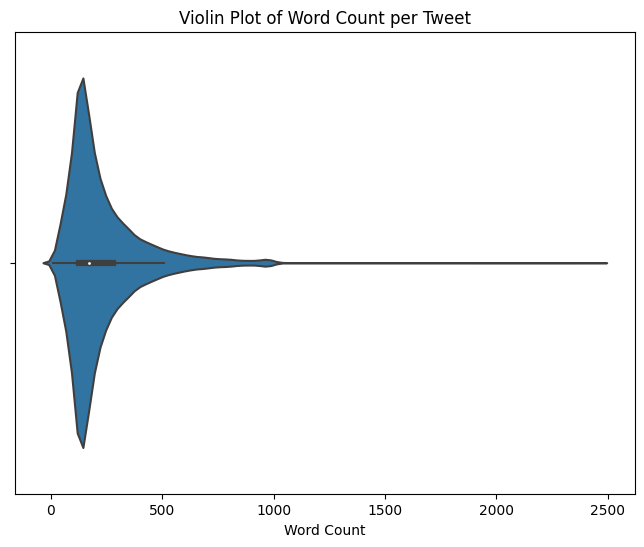

In [13]:
train_df['word_count'] =train_df['review'].apply(lambda x: len(str(x).split()))

# Calculate the statistics
plt.figure(figsize=(8, 6))
sns.violinplot(x=train_df['word_count'])
plt.title('Violin Plot of Word Count per Tweet')
plt.xlabel('Word Count')
plt.show()

In [14]:
print("Training labels distribution:", np.bincount(train_df['sentiment']))

Training labels distribution: [12500 12500]


In [15]:
train_df.drop('word_count' , axis = 1 , inplace = True)

In [16]:
# Set the model name
MODEL_NAME = 'bert-base-uncased'

#Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation = True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [18]:
df_train, df_test = train_test_split(train_df, test_size=0.1, random_state=16)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=16)

print(df_train.shape, df_val.shape, df_test.shape)

(22500, 2) (1250, 2) (1250, 2)


In [19]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.review.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [20]:
# Create train, test and val data loaders
BATCH_SIZE = 16
MAX_LEN = 500
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [21]:
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 500])
torch.Size([16, 500])
torch.Size([16])


In [22]:
bert_model = BertModel.from_pretrained(MODEL_NAME)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [23]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.2)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        # Get the pooled output (second element of the BERT output)
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = output[1]
        return self.out(pooled_output)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
# Instantiate the model and move to classifier
model = SentimentClassifier(2)
model = model.to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [26]:
print(bert_model.config.hidden_size)

768


In [30]:
EPOCHS = 4

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=True)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [31]:
from tqdm import tqdm
import torch
import numpy as np

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    # Wrap data_loader with tqdm for a progress bar
    loop = tqdm(data_loader, desc="Training Progress", leave=True)

    for d in loop:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Calculate running accuracy and loss
        running_accuracy = correct_predictions.double() / ((len(losses)) * data_loader.batch_size)
        running_loss = np.mean(losses)

        # Update tqdm progress bar with current loss and accuracy
        loop.set_postfix(loss=running_loss, accuracy=running_accuracy.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)


In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [33]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/4
----------


Training Progress: 100%|██████████| 1407/1407 [23:18<00:00,  1.01it/s, accuracy=0.902, loss=0.257]


Train loss 0.2568708300291327 accuracy 0.9021333333333333
Val   loss 0.1605829148541523 accuracy 0.9392

Epoch 2/4
----------


Training Progress: 100%|██████████| 1407/1407 [23:20<00:00,  1.00it/s, accuracy=0.958, loss=0.142]


Train loss 0.14200367556043253 accuracy 0.9583111111111111
Val   loss 0.3044646099825755 accuracy 0.9248000000000001

Epoch 3/4
----------


Training Progress: 100%|██████████| 1407/1407 [23:22<00:00,  1.00it/s, accuracy=0.98, loss=0.0803] 


Train loss 0.0803282694930314 accuracy 0.9802666666666667
Val   loss 0.2745627103177418 accuracy 0.9432

Epoch 4/4
----------


Training Progress: 100%|██████████| 1407/1407 [23:23<00:00,  1.00it/s, accuracy=0.99, loss=0.0441] 


Train loss 0.04409499580310969 accuracy 0.9904444444444445
Val   loss 0.2699820934529593 accuracy 0.9408000000000001

CPU times: user 1h 10min 40s, sys: 24min 50s, total: 1h 35min 30s
Wall time: 1h 35min 27s


In [38]:
def convert_history_to_cpu(history):
    # Convert training and validation accuracy from GPU tensors to Python floats
    history['train_acc'] = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in history['train_acc']]
    history['val_acc'] = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in history['val_acc']]
    
    # Assuming train_loss and val_loss are already floats, but you can check and convert if needed
    history['train_loss'] = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in history['train_loss']]
    history['val_loss'] = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in history['val_loss']]
    
    return history
# Convert the history values
history2 = convert_history_to_cpu(history)


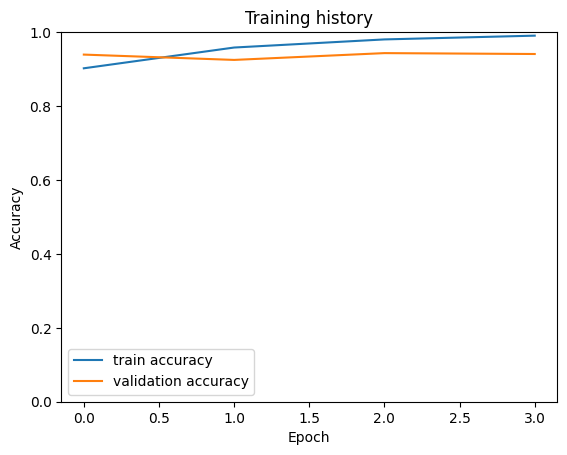

In [41]:
# Plot training and validation accuracy
plt.plot(history2['train_acc'], label='train accuracy')
plt.plot(history2['val_acc'], label='validation accuracy')

# Graph characteristics
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

plt.show()

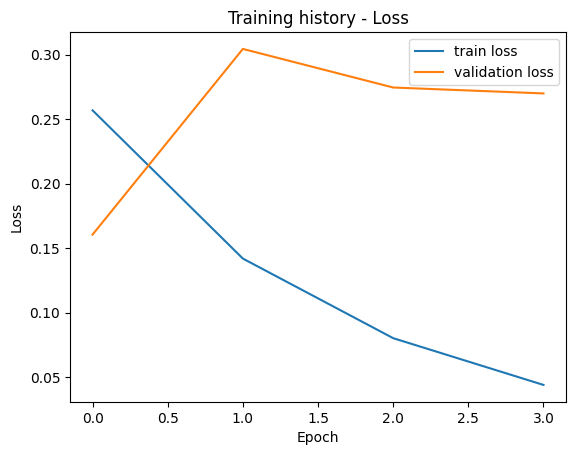

In [42]:
# Plot training and validation loss
plt.plot(history2['train_loss'], label='train loss')
plt.plot(history2['val_loss'], label='validation loss')

# Graph characteristics
plt.title('Training history - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [43]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9344

In [44]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [45]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [47]:
class_names = ['negative','positive']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.94      0.93      0.93       629
    positive       0.93      0.94      0.93       621

    accuracy                           0.93      1250
   macro avg       0.93      0.93      0.93      1250
weighted avg       0.93      0.93      0.93      1250



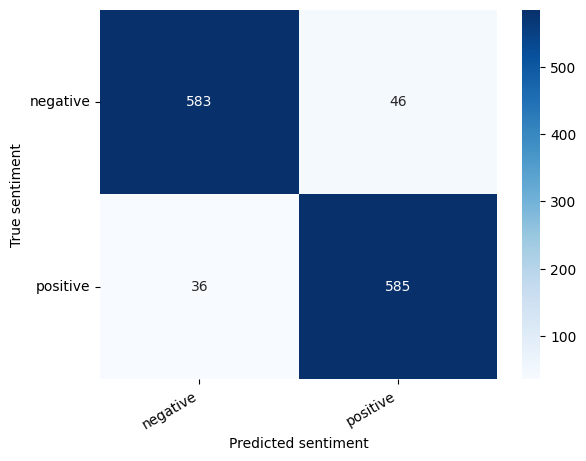

In [48]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [49]:
test_df.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [50]:
test_df['review'] = test_df['review'].apply(lambda x : x.lower())

In [51]:
test_df['review'] = test_df['review'].apply(preprocess_apply)

In [54]:
# Assuming `test_df` is already loaded and contains the test data
# Also assuming your test_df has an 'id' column and the input columns for prediction

# Create an empty list to store the predictions
predictions = []

# Iterate through the test dataset and make predictions
for index, row in test_df.iterrows():
    input_data = row['review']  # Replace 'your_input_column' with the column used for input
    
    # Make the prediction using your model
    input_ids = tokenizer.encode_plus(
        input_data,
        add_special_tokens=True,
        max_length=MAX_LEN,
        return_token_type_ids=False,
        pad_to_max_length=True,
        truncation = True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Get the model output
    with torch.no_grad():
        output = model(
            input_ids=input_ids['input_ids'].to(device),
            attention_mask=input_ids['attention_mask'].to(device)
        )
        
    # Get the predicted sentiment (0 or 1) by applying softmax and taking argmax
    _, pred = torch.max(output, dim=1)
    
    # Append the prediction to the list (id and predicted sentiment)
    predictions.append({
        'id': row['id'],  # Assuming your test_df has an 'id' column
        'sentiment': pred.item()  # Convert tensor to scalar
    })

# Convert predictions list into a DataFrame
predictions_df = pd.DataFrame(predictions)

# Save the predictions DataFrame to a CSV file
predictions_df.to_csv('submission.csv', index=False)

print('Predictions saved to predictions.csv')


Predictions saved to predictions.csv
